#Connect to drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1LRDqoHBsKCFWi3z-Hv1rH_faI3hVcyc4/Challenge2


#Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.15.0


#Load data

##unzip data

In [3]:
import zipfile
unzip=False
if unzip:
  extracted_dir = 'training_dataset'
  with zipfile.ZipFile('training_dataset.zip', 'r') as zip_ref:
      zip_ref.extractall(extracted_dir)
  print(f"Successfully extracted contents to {extracted_dir}")

##load

In [4]:
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge2/training_dataset

/gdrive/.shortcut-targets-by-id/1LRDqoHBsKCFWi3z-Hv1rH_faI3hVcyc4/Challenge2/training_dataset


###categories

In [5]:
categories=np.load('categories.npy')

In [6]:
categories.shape

(48000,)

In [7]:
unique_elements, counts = np.unique(categories, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"Element: {element}, Count: {count}")

Element: A, Count: 5728
Element: B, Count: 10987
Element: C, Count: 10017
Element: D, Count: 10016
Element: E, Count: 10975
Element: F, Count: 277


In [8]:
cambi=0
first=categories[0]
print(first)
for i in range(1,categories.shape[0]):
  if categories[i-1]!=categories[i]:
    cambi+=1
    next=categories[i]
    print(next, 'i: ',i)


D
E i:  10016
A i:  20991
C i:  26719
B i:  36736
F i:  47723


###valid_periods

In [9]:
valid_periods=np.load('valid_periods.npy')

In [10]:
valid_periods.shape

(48000, 2)

In [11]:
valid_periods[0] #start and final sample idx where the zero padding has been inserted

array([2325, 2776])

###training_data

In [12]:
training_data=np.load('training_data.npy')

In [13]:
training_data.shape # all the signals have length = 2776 thanks to the zero padding

(48000, 2776)

In [14]:
2776/40

69.4

### plot some signals

In [15]:
s = [0]*unique_elements.shape[0]
classes = [[0,10016],[10016+1,20991],[20991+1,26719],[26719+1,36736],[36736+1,47723],[47723+1,48000]]
for i in range(unique_elements.shape[0]):
  s[i] = np.random.randint(classes[i][0], classes[i][1])

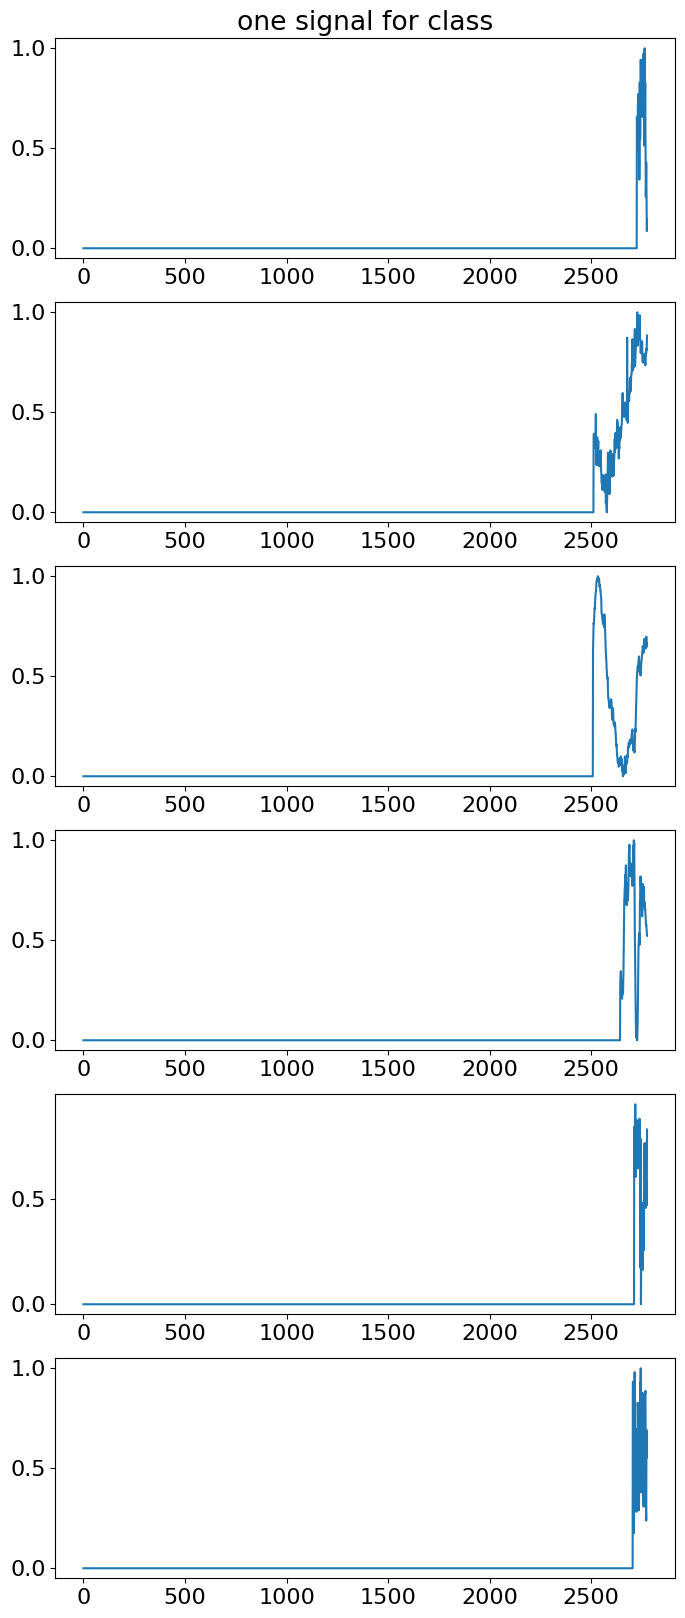

In [16]:
plt.figure(figsize=(8,20))
plt.subplot(6,1,1)
plt.plot(training_data[s[0]])
plt.title('one signal for class')
plt.subplot(6,1,2)
plt.plot(training_data[s[1]])
plt.subplot(6,1,3)
plt.plot(training_data[s[2]])
plt.subplot(6,1,4)
plt.plot(training_data[s[3]])
plt.subplot(6,1,5)
plt.plot(training_data[s[4]])
plt.subplot(6,1,6)
plt.plot(training_data[s[5]])

In [17]:
def plot_class_signal(classe, num_plot): #inserire class and number of plot to display
  classes = [[0,10016],[10016+1,20991],[20991+1,26719],[26719+1,36736],[36736+1,47723],[47723+1,48000]]
  plt.figure(figsize=(8,50))
  for i in range(num_plot):
    temp = np.random.randint(classes[classe][0], classes[classe][1])
    plt.subplot(num_plot,1,i+1)
    plt.plot(training_data[temp])

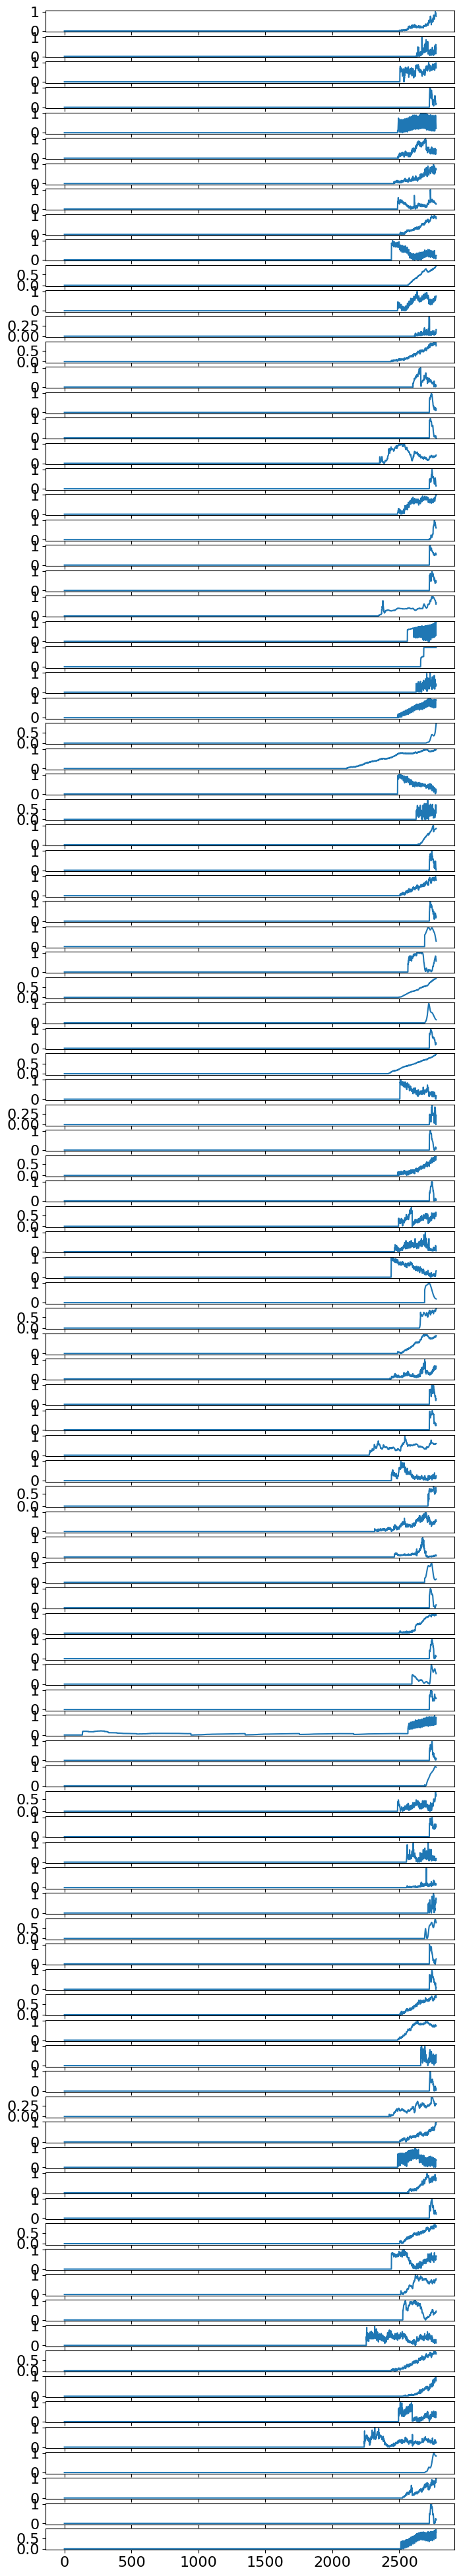

In [18]:
plot_class_signal(0,100) # we can run this code several times. the signal will be generated randomly

#Extract valid signals
capito l'asse delle x in riferimento a valid_period voglio capire ora come sono i diversi segnali lungo la y e se la loro distribuzione può essere comparabile. per fare questo devo prima estrarre le singole finestre in cui il segnale non è nullo (se un segnale lungo 2500 è 0 per 2000 campioni la sua media sarà per lo più nulla, poi così vedo anche la distribuzione delle lunghezze del valid period)

In [19]:
def extract_valid_signals(training_data,valid_periods):
  #input:
  #training_data numpy(48000,2776)
  #valid_periods numpy(48000,2)
  #output:
  #valid_signals numpy(48000,) it is composed, in each row, by an array of different shape containing only the valid signal (not padded)

  valid_signal=[0]*training_data.shape[0]
  for i in range(training_data.shape[0]):
    valid_signal[i]=training_data[i,valid_periods[i][0]:valid_periods[i][1]]

  return np.array(valid_signal)

In [20]:
valid_signal=extract_valid_signals(training_data,valid_periods)

In [21]:
valid_signal.shape

(48000,)

In [22]:
valid_signal[306].shape

(1088,)

#Exploratory data analysis

##Compare valid period length

minimum length:  24
maximum length:  2776
mean length:  198.30022916666667


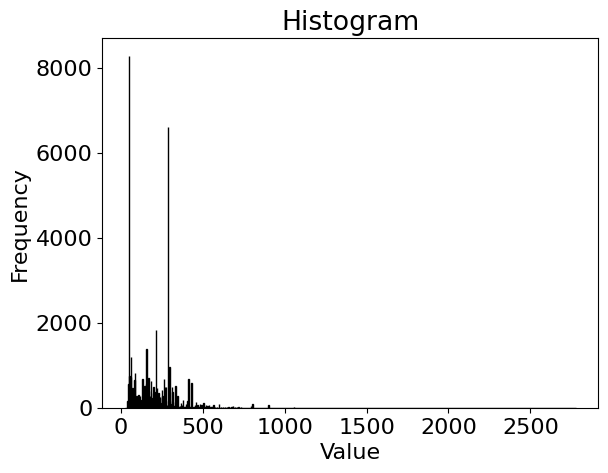

In [23]:
lengths=[]
for i in range(valid_signal.shape[0]):
  lengths.append(len(valid_signal[i]))
lengths=np.array(lengths)
print('minimum length: ',np.min(lengths))
print('maximum length: ',np.max(lengths))
print('mean length: ',np.mean(lengths))

plt.hist(lengths, bins=1000, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()


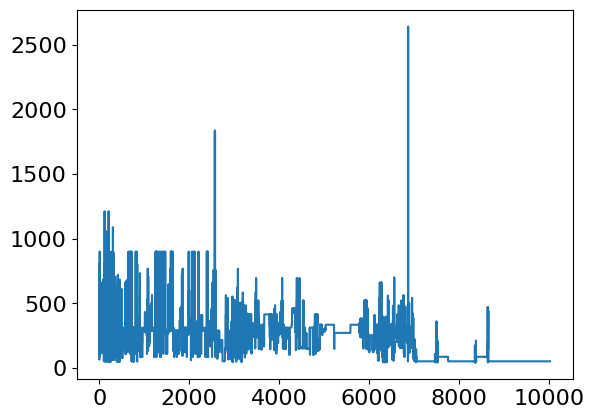

In [24]:
plt.plot(lengths[:10016])

Text(0.5, 1.0, 'Length of valid signals clustered by class')

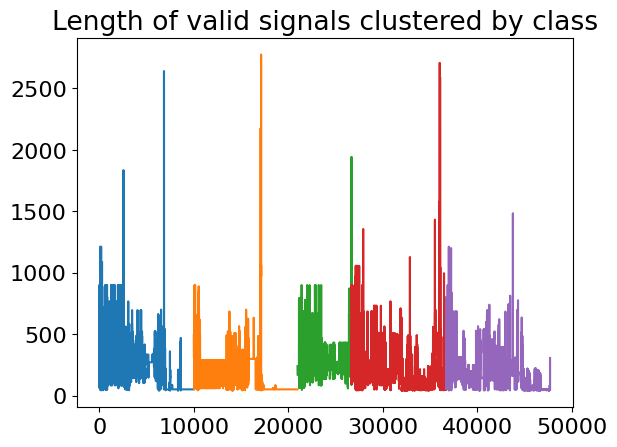

In [25]:
start=0
plt.figure
for i in range(1,categories.shape[0]):
  if categories[i-1]!=categories[i]:
    plt.plot(range(start,i),lengths[start:i])
    start=i
plt.title('Length of valid signals clustered by class')

In [26]:
# count how many are longer than threshold
threshold=1000
count=np.sum(lengths>threshold)
print('number of valid signals longer than ',threshold,' samples: ', count)

number of valid signals longer than  1000  samples:  45


In [27]:
# count how many are longer than threshold
threshold=50
count=np.sum(lengths<threshold)
print('number of valid signals shorter than ',threshold,' samples: ', count)

number of valid signals shorter than  50  samples:  2017


##compare y distribution

In [28]:
minimi=[]
massimi=[]
medie= []
st_dev=[]
dyn_range=[]

for i in range(valid_signal.shape[0]):
  minimi.append(np.min(valid_signal[i]))
  massimi.append(np.max(valid_signal[i]))
  medie.append(np.mean(valid_signal[i]))
  st_dev.append(np.std(valid_signal[i]))
  dyn_range.append(np.max(valid_signal[i])-np.min(valid_signal[i]))
minimi=np.array(minimi)
massimi=np.array(massimi)
medie=np.array(medie)
st_dev=np.array(st_dev)
dyn_range=np.array(dyn_range)

In [29]:
print(np.mean((dyn_range)))
print(np.std((dyn_range)))

0.934708640131671
0.11580073531118984


minimum length:  0.0
maximum length:  0.8094591554727169
mean length:  0.019058547066827927


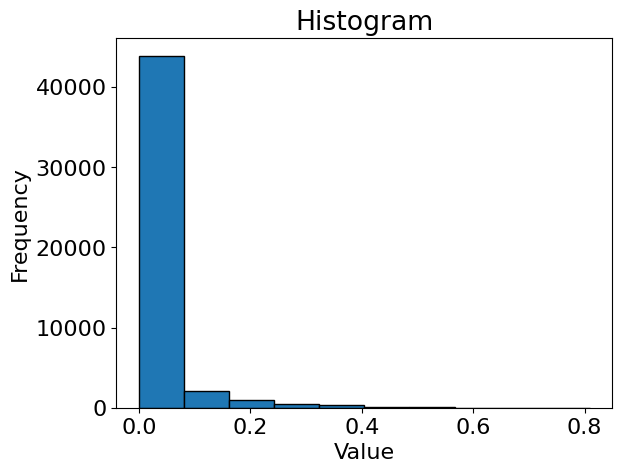

minimum length:  0.017374517374517374
maximum length:  1.0
mean length:  0.953767187198499


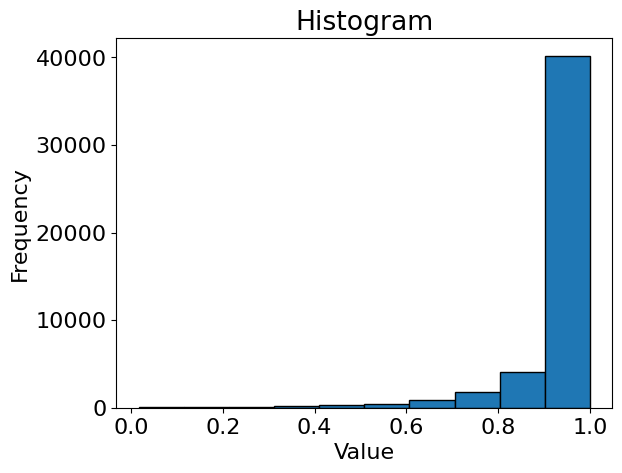

minimum length:  0.003293209175562116
maximum length:  0.9958379784466772
mean length:  0.43361450911761834


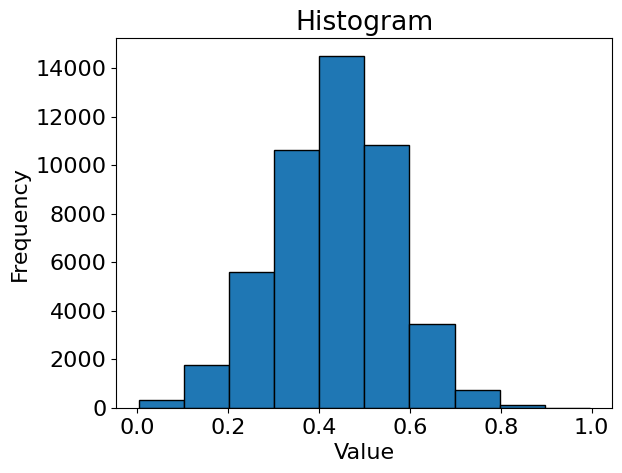

minimum length:  0.002918854969892801
maximum length:  0.47154209165073785
mean length:  0.23411373351247247


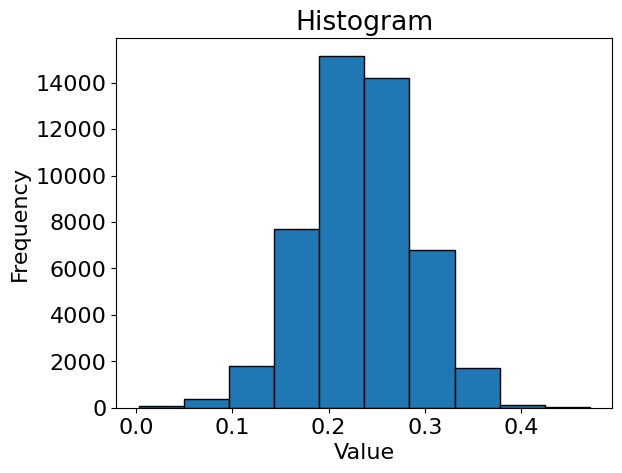

minimum length:  0.017374517374517374
maximum length:  1.0
mean length:  0.934708640131671


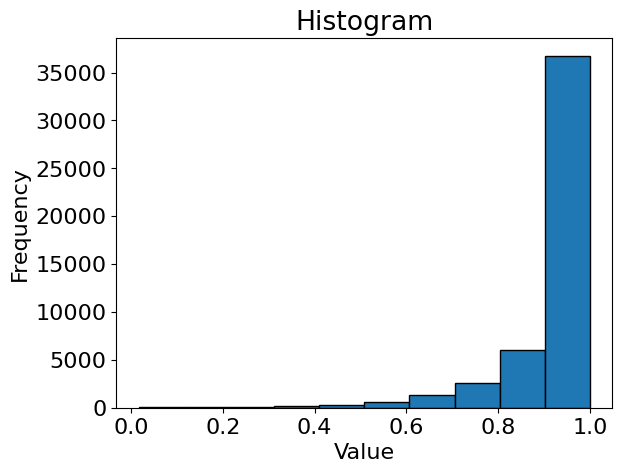

In [30]:
for metrica in [minimi,massimi,medie,st_dev,dyn_range]:
  print('minimum length: ',np.min(metrica))
  print('maximum length: ',np.max(metrica))
  print('mean length: ',np.mean(metrica))

  plt.hist(metrica, bins=10, edgecolor='black')  # Adjust the number of bins as needed
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Histogram')
  plt.show()

In [31]:
# count how many are longer than threshold
threshold=0.5
count=np.sum(dyn_range<threshold)
print('number of valid signals with dynamic range shorter than ',threshold,' samples: ', count)

number of valid signals with dynamic range shorter than  0.5  samples:  613


(0.0, 1.0)

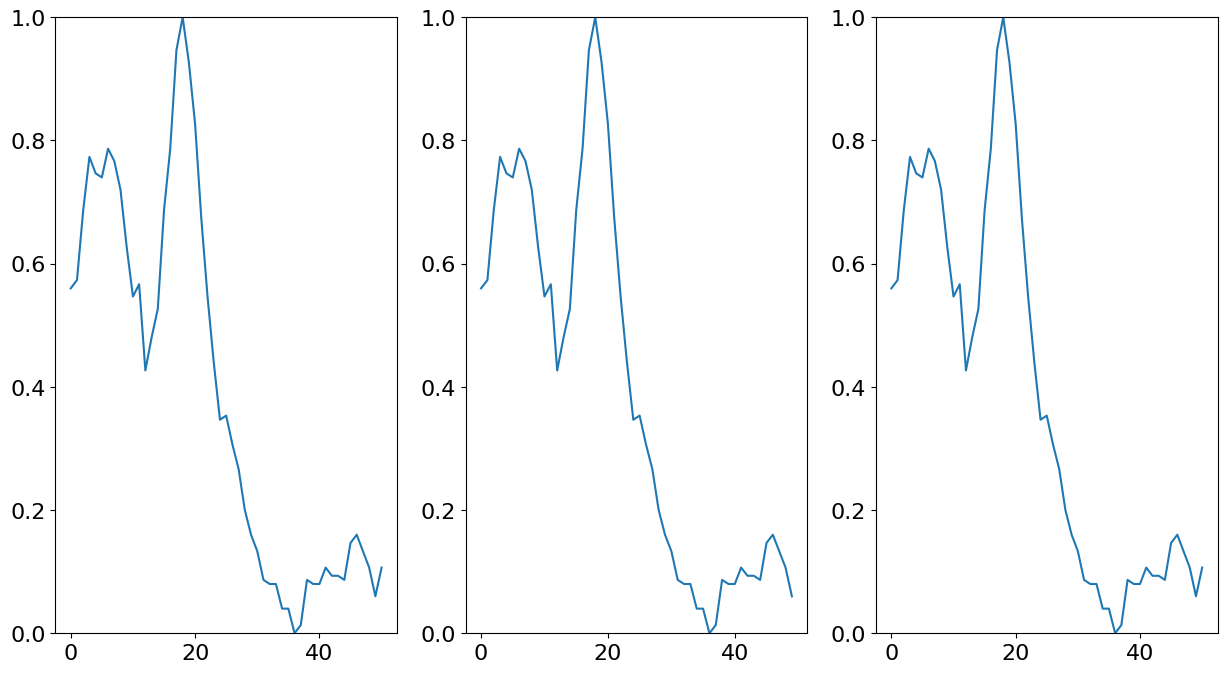

In [32]:
start=10000
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.plot(valid_signal[start][:])
plt.ylim(0,1)
plt.subplot(1,3,2)
plt.plot(valid_signal[start][:50])
plt.ylim(0,1)
plt.subplot(1,3,3)
plt.plot(valid_signal[start][:50+18])
plt.ylim(0,1)

In [33]:
mean_val=[]
for i in range(valid_signal.shape[0]):
  mean_val.append(np.mean(valid_signal[i]))
mean_val=np.array(mean_val)
mean_mean=np.mean(mean_val)
std_mean=np.std(mean_val)

In [34]:
std_mean

0.12986243269643474

In [35]:
mean_mean

0.43361450911761834

#Information in window

In [36]:
data_train = np.load('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/X_train.npy',allow_pickle=True)
data_val = np.load('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/X_val.npy',allow_pickle=True)
data_test = np.load('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/X_test.npy',allow_pickle=True)
print(data_train.shape, data_val.shape,data_test.shape)

(33596,) (7198,) (6,)


In [37]:
def build_sequences(training_data, window, stride, telescope):
    dataset = [0]*training_data.shape[0]
    labels = [0]*training_data.shape[0]
    for i in range(training_data.shape[0]): #48.000 sgnali
      #vediamo la lunghezza di ciascuno e in base a questa andiamo ad aggiustare il padding quanto serve
      assert window % stride == 0 #TOASK
      temp_df = training_data[i].copy()
      temp_label = training_data[i].copy() #target is the signal itself
      padding_check = len(training_data[i])%window

      if(padding_check != 0):
          # Compute padding length
          padding_len = window - len(training_data[i])%window
          padding = np.zeros((padding_len), dtype='float32')
          temp_df = np.concatenate((padding,training_data[i])) # NEW SIGNAL AFTER PADDING
          temp_label = np.concatenate((padding,temp_label)) # NEW TARGET (= SIGNAL) AFTER PADDINNG
          assert len(temp_df) % window == 0

      temp_final_dataset = []
      tempp_final_lable = []
      for idx in np.arange(0,len(temp_df)-window-telescope,stride): # i want to save all the windows in the first position
          temp_final_dataset.append(temp_df[idx:idx+window])
          tempp_final_lable.append(temp_label[idx+window:idx+window+telescope])

      dataset[i] = np.array(temp_final_dataset)
      labels[i] = np.array(tempp_final_lable)

    return np.array(dataset), np.array(labels)

In [38]:
def extract_window(X_train, y_train):
  X_train_final = []
  y_train_final = []
  for i in range(X_train.shape[0]):
    for ii in range(X_train[i].shape[0]):
      X_train_final.append(X_train[i][ii])
      y_train_final.append(y_train[i][ii])
  return np.array(X_train_final), np.array(y_train_final)


In [39]:
X,y = build_sequences(valid_signal, 50, 10, 18)
X,y = extract_window(X, y)

In [40]:
dyn_range=[]
for i in range(X.shape[0]):
  dyn_range.append(np.max(X[i])-np.min(X[i]))
dyn_range=np.array(dyn_range)

mean length:  0.4000333067780837
std length:  0.25699679892682264


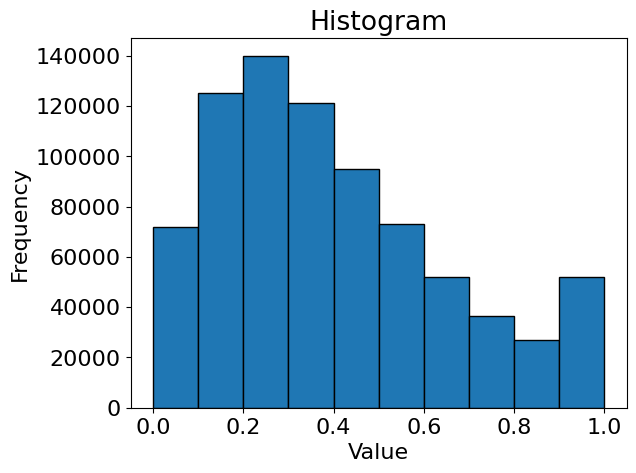

In [41]:
print('mean length: ',np.mean(dyn_range))
print('std length: ',np.std(dyn_range))
plt.hist(dyn_range, bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

### Plot some signals

In [42]:
s = [0]*unique_elements.shape[0]
classes = [[0,10016],[10016+1,20991],[20991+1,26719],[26719+1,36736],[36736+1,47723],[47723+1,48000]]
for i in range(unique_elements.shape[0]):
  s[i] = np.random.randint(classes[i][0], classes[i][1])

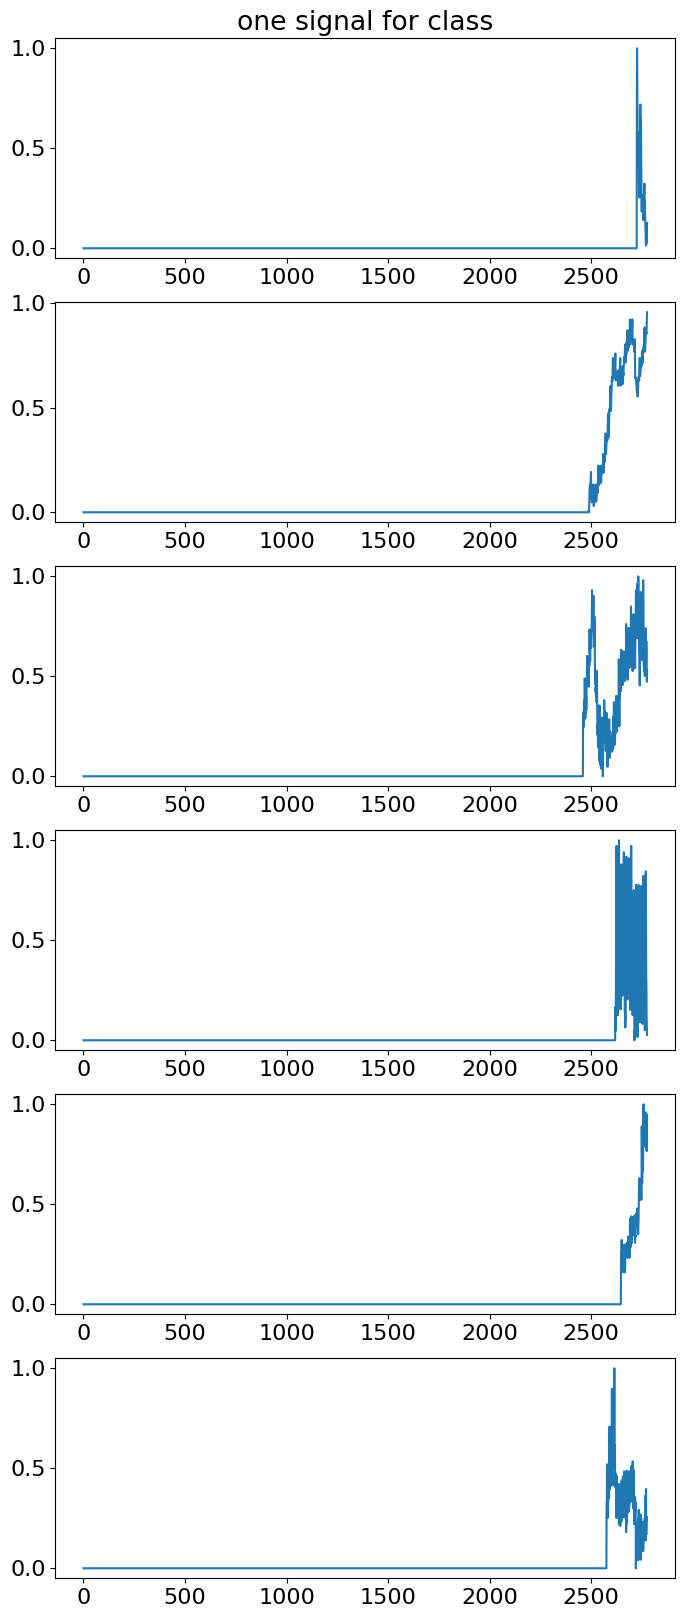

In [43]:
plt.figure(figsize=(8,20))
plt.subplot(6,1,1)
plt.plot(training_data[s[0]])
plt.title('one signal for class')
plt.subplot(6,1,2)
plt.plot(training_data[s[1]])
plt.subplot(6,1,3)
plt.plot(training_data[s[2]])
plt.subplot(6,1,4)
plt.plot(training_data[s[3]])
plt.subplot(6,1,5)
plt.plot(training_data[s[4]])
plt.subplot(6,1,6)
plt.plot(training_data[s[5]])

In [44]:
def plot_class_signal(classe, num_plot): #inserire class and number of plot to display
  classes = [[0,10016],[10016+1,20991],[20991+1,26719],[26719+1,36736],[36736+1,47723],[47723+1,48000]]
  plt.figure(figsize=(8,50))
  for i in range(num_plot):
    temp = np.random.randint(classes[classe][0], classes[classe][1])
    plt.subplot(num_plot,1,i+1)
    plt.plot(training_data[temp])

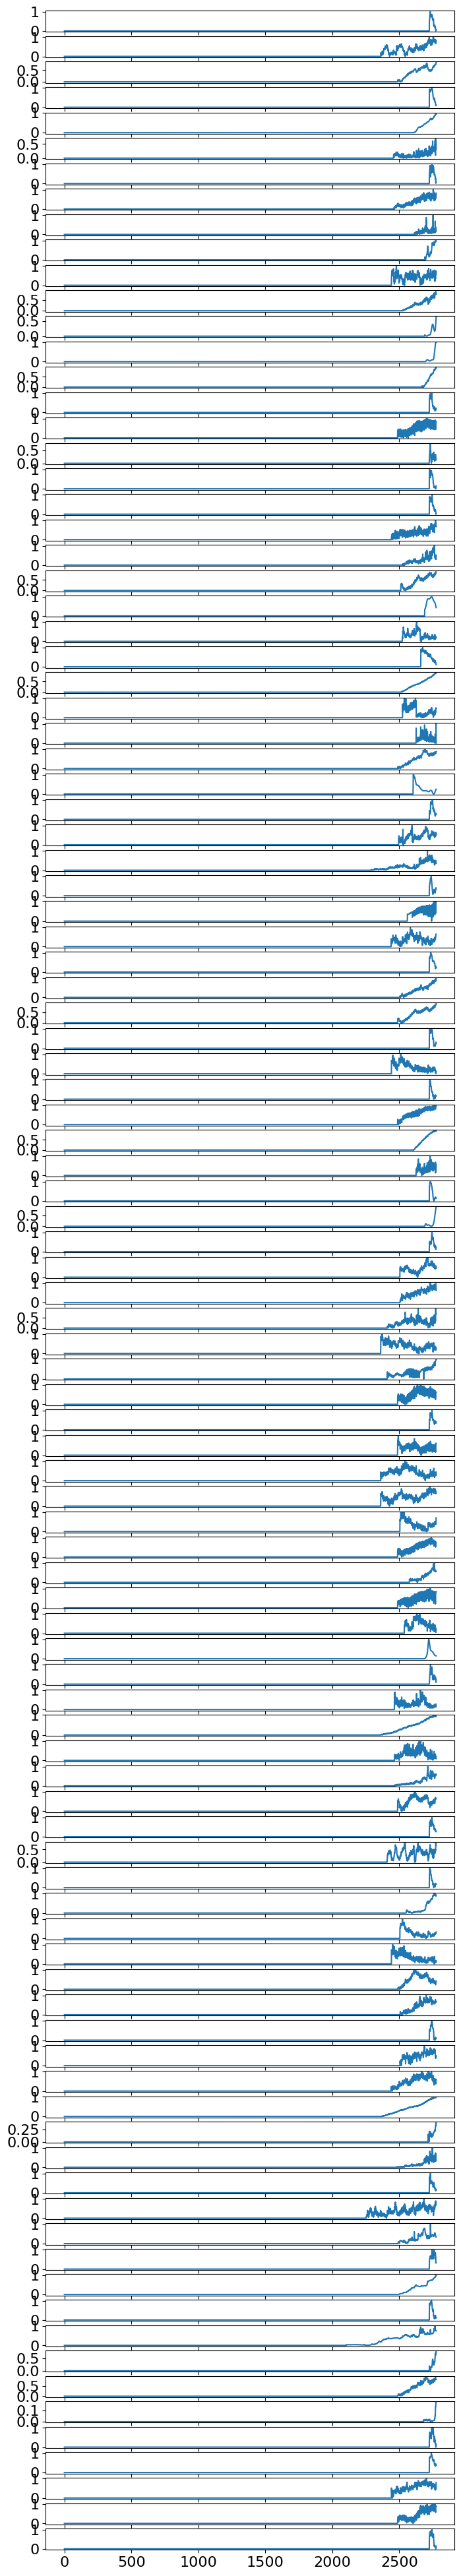

In [45]:
plot_class_signal(0,100) # we can run this code several times. the signal will be generated randomly